<a href="https://colab.research.google.com/github/luizmv8080/aprendizaje-profundo/blob/main/Tarea1/Ejercicio_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresion lineal con Pytorch

### Grafica los datos en 3D.

In [206]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

<b>Exportamos</b> el dataset

In [207]:
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv'
data_dir = '../data'
filepath = os.path.join(data_dir, 'califs.csv')

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

! mkdir {data_dir}
! wget -nc {URL} -O {filepath}

mkdir: cannot create directory ‘../data’: File exists
File ‘../data/califs.csv’ already there; not retrieving.


In [208]:
#Echamos un vistazo a los datos importados
df = pd.read_csv(filepath)
df.head(2)

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9


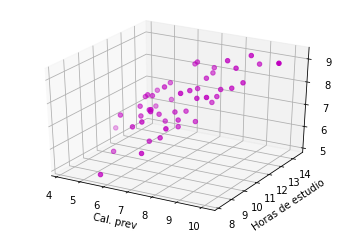

In [209]:
# Creamos la figura
fig = plt.figure()
# Creamos el plano 3D
ax1 = fig.add_subplot(111, projection='3d')

# Definimos los datos de prueba
x = df['prev']
y = df['horas']
z = df['calif']

# Agregamos los puntos en el plano 3D
ax1.scatter(x, y, z, c='m', marker='o')

# Mostramos el gráfico
plt.xlabel('Cal. prev')
plt.ylabel('Horas de estudio')
plt.show()

Vemos como todo el conjunto de datos si tiene un comportamiento <b>lineal</b>.

Convertimos en tensores las variables dependientes y la independiente:

In [210]:
#Para la variable dependiente creamos un array que contenga las dos primeras columnas
x_trn = np.array(df.iloc[:,:2], dtype="float32")
#Para la variable independiente creamos un array que contenga solo la ultima columna
y_trn = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]

#Los convertimos en tensores de torch
x_trn = torch.tensor(x_trn)
y_trn = torch.tensor(y_trn)

#Observamos sus dimensiones 
print("Dimension del conjunto de entrenamiento de la variable independiente 'x': "+str(x_trn.shape))
print("Dimension del conjunto de entrenamiento de la variable dependiente 'y': "+str(y_trn.shape))

Dimension del conjunto de entrenamiento de la variable independiente 'x': torch.Size([50, 2])
Dimension del conjunto de entrenamiento de la variable dependiente 'y': torch.Size([50, 1])


Creamos el objeto <b>TensorDataset</b>:

In [211]:
ds = TensorDataset(x_trn, y_trn)

Creamos el objeto <b>dataLoader</b> que nos ayudara a recorrer el dataset por mini batches

In [212]:
#Creamos una funcion que automaticamente cree el dataLoader del dataset "ds"
def build_dl(batch_size=16, shuffle=True):
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

#Creamos el dataLoader (ds)
dl = build_dl()

#Vemos que forma tienen los objetos provenientes del dL
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32


## Entrenamiento en alto nivel

Creamos la funcion de <b>entrenamiento</b>, utilizando el codigo visto en clase:

In [213]:
def getR2(y,y_pred):
  
  df_rdc['SSR']=(y_pred-np.mean(y))**2
  df_rdc['SST']=(y-np.mean(y))**2

  SSR = sum(df_rdc['SSR'])
  SST = sum(df_rdc['SST'])

  R2 = SSR/SST
  return R2

In [214]:
def train(model, dl, lr, epochs=10):

    opt = optim.SGD(model.parameters(), lr=lr)
    #lr=0.0015
    # historial de pérdida
    loss_hist = []

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # historial
        loss_hist = []
        
        # entrenamiento de una época
        for x, y_true in dl:
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos de pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # vaciamos los gradientes
            opt.zero_grad()
            # retropropagamos
            loss.backward()
            # actulizamos parámetros
            opt.step()

            # guardamos historial de pérdida
            loss_hist.append(loss.item() * 100)
        # imprimimos la pérdida de la época
        loss = np.mean(loss_hist)

        #Imprimimos solo la ultima cantidad de perdida para no llenar de informacion
        if epoch == (epochs - 1):
          print(f'E{epoch:02} loss=[{loss:6.2f}]')


        
def train_model(build_model, lr, epochs=900):
    set_seed()
    dl = build_dl()
    model = build_model
    train(model, dl, lr, epochs)

Creamos otro modelo donde haya <b>una capa oculta</b>:

In [215]:
def build_high_one(n_capa_uno):
    model = nn.Sequential(
        nn.Linear(2, n_capa_uno),
        nn.ReLU(),
        nn.Linear(n_capa_uno, 1),
        nn.ReLU()

    )
    return model

Creamos otro modelo donde haya <b>dos capas ocultas</b>:

In [216]:
def build_high_two(n_capa_uno,n_capa_dos):
    model = nn.Sequential(
        nn.Linear(2, n_capa_uno),
        nn.ReLU(),
        nn.Linear(n_capa_uno, n_capa_dos),
        nn.ReLU(),
        nn.Linear(n_capa_dos, 1),
        nn.ReLU()

    )
    return model

### Creamos el modelo que tiene solo una capa oculta:

In [217]:
learning_rate = [0.001, 0.005, 0.01]
numero_capas = [11,10,6,4]
for i in numero_capas:
  high_one = build_high_one(i)
  for j in learning_rate:
    print("Para un numero de neuronas de. {0} en la primera capa y un lr de {1} se tiene una perdida de:".format(i,j))
    train_model(high_one, j)
  print("=====================================================")

Para un numero de neuronas de. 11 en la primera capa y un lr de 0.001 se tiene una perdida de:
E899 loss=[ 26.96]
Para un numero de neuronas de. 11 en la primera capa y un lr de 0.005 se tiene una perdida de:
E899 loss=[ 46.84]
Para un numero de neuronas de. 11 en la primera capa y un lr de 0.01 se tiene una perdida de:
E899 loss=[107.67]
Para un numero de neuronas de. 10 en la primera capa y un lr de 0.001 se tiene una perdida de:
E899 loss=[5601.83]
Para un numero de neuronas de. 10 en la primera capa y un lr de 0.005 se tiene una perdida de:
E899 loss=[5601.83]
Para un numero de neuronas de. 10 en la primera capa y un lr de 0.01 se tiene una perdida de:
E899 loss=[5601.83]
Para un numero de neuronas de. 6 en la primera capa y un lr de 0.001 se tiene una perdida de:
E899 loss=[ 25.64]
Para un numero de neuronas de. 6 en la primera capa y un lr de 0.005 se tiene una perdida de:
E899 loss=[ 46.45]
Para un numero de neuronas de. 6 en la primera capa y un lr de 0.01 se tiene una perdida 

Vemos que la mejor opcion es crear una primera capa de **6 neuronas** y un **lr = 0.001**:

In [219]:
high_one = build_high_one(6)
train_model(high_one, 0.0001)

E899 loss=[ 24.02]


Obtenemos los parametros **(w1,w2,b1,b2)**

In [220]:
lista_parametros = list(high_one.named_parameters())

Creamos nuestra red con los parametros optimizados:

In [223]:
def redNeuronalUno(x,w1,w2,b1,b2):
  
  X = x[:,np.newaxis]
  z = np.dot(w1,X) + b1.T
  a1 = np.maximum(0,z)
  z2 = np.dot(w2,z) + b2
  pred = np.maximum(0,z2)

  return pred.item()

In [224]:
#Asignamos los valores optimos a nuestros parametros
w1_1 = lista_parametros[0][1].detach().numpy()
b1_1 = np.array([lista_parametros[1][1].detach().numpy()])
w2_1 = lista_parametros[2][1].detach().numpy()
b2_1 = lista_parametros[3][1].detach().numpy().item()

y_prediccion_dos = []
for i in range(x_trn.shape[0]):
  y_prediccion_dos.append(redNeuronalUno(x_trn[i],w1_1,w2_1,b1_1,b2_1))

In [225]:
#Llamamos df_ruc de "red de una capa"
df_rdc = df.copy()
df_rdc['Prediccion'] = y_prediccion_dos
df_rdc.head(3)

,prev,horas,calif,Prediccion
0,5.6,8.2,5.1,5.026355
1,6.7,9.3,5.9,5.719257
2,5.1,10.0,5.4,6.093335


In [226]:
getR2(df_rdc['calif'],df_rdc['Prediccion'])

0.744174484882838

#Creando el modelo que tiene dos capas ocultas

In [227]:
numero_capas = [11,10,6,4]
numero_capas_dos = [6, 4, 2]
for i in numero_capas:
  #high_two = build_high_two(i)
  for j in numero_capas_dos:
    high_two = build_high_two(i,j)
    print("Para un numero de neuronas de. {0} en la primera capa y {1} en la segunda capa, se tiene una perdida de:".format(i,j))
    train_model(high_two, 0.001)
  print("=====================================================")

Para un numero de neuronas de. 11 en la primera capa y 6 en la segunda capa, se tiene una perdida de:
E899 loss=[ 26.73]
Para un numero de neuronas de. 11 en la primera capa y 4 en la segunda capa, se tiene una perdida de:
E899 loss=[5601.83]
Para un numero de neuronas de. 11 en la primera capa y 2 en la segunda capa, se tiene una perdida de:
E899 loss=[ 28.29]
Para un numero de neuronas de. 10 en la primera capa y 6 en la segunda capa, se tiene una perdida de:
E899 loss=[5601.83]
Para un numero de neuronas de. 10 en la primera capa y 4 en la segunda capa, se tiene una perdida de:
E899 loss=[ 27.07]
Para un numero de neuronas de. 10 en la primera capa y 2 en la segunda capa, se tiene una perdida de:
E899 loss=[5601.83]
Para un numero de neuronas de. 6 en la primera capa y 6 en la segunda capa, se tiene una perdida de:
E899 loss=[5601.83]
Para un numero de neuronas de. 6 en la primera capa y 4 en la segunda capa, se tiene una perdida de:
E899 loss=[ 25.98]
Para un numero de neuronas de.

In [228]:
high_two = build_high_two(6,2)
train_model(high_two, 0.0001)

E899 loss=[ 23.49]


In [229]:
lista_parametros_dos = list(high_two.named_parameters())

In [230]:
def redNeuronalDos(x,w1,w2,w3,b1,b2,b3):
  
  X = x[:,np.newaxis]
  z1 = np.dot(w1,X) + b1.T
  a1 = np.maximum(0,z1)
  z2 = np.dot(w2,a1) + b2.T
  a2 = np.maximum(0,z2)
  z3 = np.dot(w3,a2) + b3
  pred = np.maximum(0,z3)
  return pred.item()

In [231]:
w1_2 = lista_parametros_dos[0][1].detach().numpy()
b1_2 = np.array([lista_parametros_dos[1][1].detach().numpy()])
w2_2 = lista_parametros_dos[2][1].detach().numpy()
b2_2 = np.array([lista_parametros_dos[3][1].detach().numpy()])
w3_2 = lista_parametros_dos[4][1].detach().numpy()
b3_2 = lista_parametros_dos[5][1].detach().numpy().item()

y_prediccion_dos = []
for i in range(x_trn.shape[0]):
  y_prediccion_dos.append(redNeuronalDos(x_trn[i],w1_2,w2_2,w3_2,b1_2,b2_2,b3_2))

In [232]:
df_rdc = df.copy()
df_rdc['Prediccion'] = y_prediccion_dos
df_rdc.head(3)

,prev,horas,calif,Prediccion
0,5.6,8.2,5.1,5.099682
1,6.7,9.3,5.9,5.858493
2,5.1,10.0,5.4,5.949234


In [233]:
getR2(df_rdc['calif'],df_rdc['Prediccion'])

0.7421194837146154

## Prediccion para un alumno que estudió durante 12 horas para el examen y en un examen previo obtuvo 3 de calificación.

### Para nuestra red con una sola capa se tiene:

In [234]:
redNeuronalUno(np.array([3,12]),w1_1,w2_1,b1_1,b2_1)

7.233971218601225

### Para nuestra red con dos capas se tiene:

In [235]:
redNeuronalDos(np.array([3,12]),w1_2,w2_2,w3_2,b1_2,b2_2,b3_2)

6.629859603316729

# Resultados de construccion de red neuronal de alto nivel

### Con una red de una sola capa oculta

Se creo una red con una sola capa oculta. Esa capa oculta cuenta con 6 neuronas. Se escogio un **learning rate** de **0.001** ya que minimizaba la perdida a un **25.64%**. Tambien se calculo que el **R2** fue de **0.73**.

Respecto a la prediccion de un estudiante que estudió durante 12 horas para el examen y en un examen previo obtuvo 3 de calificación, se obtuvo que sacaria una calificacion de **7.23**.

### Con red de dos capas ocultas

Se creo una red con dos capas ocultas. La segunda capa oculta solo contaba con 2 neuronas, mientras que la primera capa oculta conto con 6 neuronas. Se escogio un **learning rate** de **0.001** ya que minimizaba la perdida a un **23.49%**. Tambien se calculo que el **R2** fue de **0.74**, el cual es mayor que para una arquitectura de una sola capa oculta.

Respecto a la prediccion de un estudiante que estudió durante 12 horas para el examen y en un examen previo obtuvo 3 de calificación, se obtuvo que sacaria una calificacion de **6.62**. Vemos que ambas predicciones se mantienen en el rango.
